In [94]:
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import optax as ox
from jax import jit
from shgp import SHGP_jax
import gpjax as gpx
import jax.scipy as jsp
from gpjax.parameters import transform
from gpjax.kernels import cross_covariance, diagonal, gram
from gpjax.utils import I, concat_dictionaries
import jax.lax as lax
from jax import vmap


key = jr.PRNGKey(123)
from gpjax.utils import I, concat_dictionaries
from gpjax.kernels import cross_covariance, diagonal, gram
default_jitter = jnp.asarray(1.e-6)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [99]:
n = 50
n_realisations = 4
noise = .5

x = jr.uniform(key=key, minval=-3.0, maxval=3.0, shape=(n,)).sort().reshape(-1, 1)
f_group = lambda x: 0.5 * (jnp.sin(2 *  x) + x * jnp.cos(5 *  x))
latent_signal = f_group(x)

prior = gpx.Prior(kernel=gpx.kernels.Matern32())
params, _, _, _ = gpx.initialise(prior, key).unpack()
f_indi = lambda x: prior(params)(x)
y_indi = f_indi(x).sample(sample_shape=n_realisations, seed=key).T + latent_signal

# Data
x = x 
y=y_indi

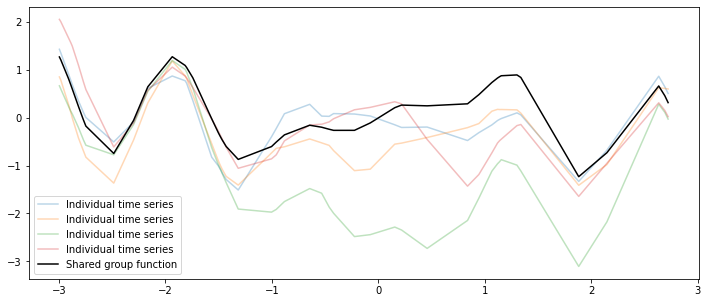

In [100]:
plt.figure(figsize=(12, 5))
[plt.plot(x, y_r, alpha=0.3, label='Individual time series') for y_r in y.T]
plt.plot(x, latent_signal, color='black', label='Shared group function')
plt.legend()
plt.show()


In [101]:
m = jnp.asarray(15)
z = jnp.linspace(-3.0, 3.0, m).reshape(-1, 1)

In [102]:
data=(x, y)
group_kernel=gpx.kernels.Matern32()
individual_kernel=gpx.kernels.Matern32()
likelihood=gpx.likelihoods.Gaussian(num_datapoints=n)
mean_function=gpx.mean_functions.Zero()

In [103]:
parameter_state_dict = dict()
parameters = dict()
trainables = dict()
constrainers = dict()
unconstrainers = dict()

# Inducing points
parameters['inducing_points'] = dict(inducing_points=m)
trainables['inducing_points'] = dict(inducing_points=True)
constrainers['inducing_points'] = dict(inducing_points=jnp.asarray) # TODO this is totally hacky and horrible...
unconstrainers['inducing_points'] = dict(inducing_points=jnp.asarray) # Could use linear bijector?

# Kernels
for i in range(n_realisations):
    name = f'kernel{i}'
    k_param_state = gpx.initialise(individual_kernel, key)
    parameters[name] = k_param_state.params
    trainables[name] = k_param_state.trainables
    constrainers[name] = k_param_state.constrainers
    unconstrainers[name] = k_param_state.unconstrainers
group_name = 'kernel_group'
kg_param_state = gpx.initialise(group_kernel, key)
parameters[group_name] = kg_param_state.params
trainables[group_name] = kg_param_state.trainables
constrainers[group_name] = kg_param_state.constrainers
unconstrainers[group_name] = kg_param_state.unconstrainers

like_name = 'likelihood'
likelihood_parameter_states = gpx.initialise(likelihood, key)
parameters[like_name] = likelihood_parameter_states.params
trainables[like_name] = likelihood_parameter_states.trainables
constrainers[like_name] = likelihood_parameter_states.constrainers
unconstrainers[like_name] = likelihood_parameter_states.unconstrainers

# Mean function
mf_name = 'mean_function'
mf_param_state = gpx.initialise(mean_function, key)
parameters[mf_name] = mf_param_state.params
trainables[mf_name] = mf_param_state.trainables
constrainers[mf_name] = mf_param_state.constrainers
unconstrainers[mf_name] = mf_param_state.unconstrainers

parameter_state_dict['params'] = parameters
parameter_state_dict['trainables'] = trainables
parameter_state_dict['constrainers'] = constrainers
parameter_state_dict['unconstrainers'] = unconstrainers

In [126]:
def calc_elbo_part(kernel, kernel_params, params, y):
    noise = params['likelihood']['obs_noise']
    z = params['inducing_points']['inducing_points']
    print(kernel)
    Kzz = gram(kernel, z, kernel_params)
    Kzz += I(m) * default_jitter
    Kzx = cross_covariance(kernel, z, x, kernel_params)
    Kxx_diag = vmap(kernel, in_axes=(0, 0, None))(
        x, x, kernel_params
    )
    μx = mean_function(x, params['mean_function'])
    Lz = jnp.linalg.cholesky(Kzz)
    A = jsp.linalg.solve_triangular(Lz, Kzx, lower=True) / jnp.sqrt(noise)
    # AAᵀ
    AAT = jnp.matmul(A, A.T)
    # B = I + AAᵀ
    B = I(m) + AAT
    # LLᵀ = I + AAᵀ
    L = jnp.linalg.cholesky(B)
    # log|B| = 2 trace(log|L|) = 2 Σᵢ log Lᵢᵢ  [since |B| = |LLᵀ| = |L|²  => log|B| = 2 log|L|, and |L| = Πᵢ Lᵢᵢ]
    log_det_B = 2.0 * jnp.sum(jnp.log(jnp.diagonal(L)))
    diff = y - μx
    # L⁻¹ A (y - μx)
    L_inv_A_diff = jsp.linalg.solve_triangular(
        L, jnp.matmul(A, diff), lower=True
    )
    # (y - μx)ᵀ (Iσ² + Q)⁻¹ (y - μx)
    quad = (jnp.sum(diff**2) - jnp.sum(L_inv_A_diff**2)) / noise
    # 2 * log N(y; μx, Iσ² + Q)
    two_log_prob = -n * jnp.log(2.0 * jnp.pi * noise) - log_det_B - quad
    # 1/σ² tr(Kxx - Q) [Trace law tr(AB) = tr(BA) => tr(KxzKzz⁻¹Kzx) = tr(KxzLz⁻ᵀLz⁻¹Kzx) = tr(Lz⁻¹Kzx KxzLz⁻ᵀ) = trace(σ²AAᵀ)]
    two_trace = jnp.sum(Kxx_diag) / noise - jnp.trace(AAT)
    # log N(y; μx, Iσ² + KxzKzz⁻¹Kzx) - 1/2σ² tr(Kxx - KxzKzz⁻¹Kzx)
    return -1. * (two_log_prob - two_trace).squeeze() / 2.0

In [127]:
def total_elbo(params):
    loss_sum = 0.0
    for i in jnp.arange(n_realisations):
        for j in jnp.arange(n_realisations):
            if i == j:
                kernel = individual_kernel + group_kernel
                kernel_params = [params[f'kernel{i}'], params['kernel_group']]
                kernel_unconstrainers = [parameter_state_dict['unconstrainers'][f'kernel{i}'], parameter_state_dict['unconstrainers']['kernel_group']]
            else:
                kernel = group_kernel
                kernel_params = params['kernel_group']
                kernel_unconstrainers = parameter_state_dict['unconstrainers']['kernel_group']

            y_ = y[:, i]
            x_ = x
            unc_params = transform(params, unconstrainers)
            unc_kernel_params = transform(kernel_params, kernel_unconstrainers)
            loss_sum = loss_sum + calc_elbo_part(kernel, unc_kernel_params, unc_params, y_)

    return loss_sum

In [128]:
total_elbo(parameter_state_dict['params'])

SumKernel(kernel_set=[<gpjax.kernels.Matern32 object at 0x7f47aeca48b0>, <gpjax.kernels.Matern32 object at 0x7f47aeca5f60>], active_dims=None, stationary=False, spectral=False, name='Sum kernel', combination_fn=<function sum at 0x7f497d71bd00>)


/tmp/ipykernel_2023343/1190730749.py:16: DeprecationWarning: `transform` will be deprecated in a future release. As of v0.5.0, please use `constrain` or `unconstrain` instead.
  unc_params = transform(params, unconstrainers)
/tmp/ipykernel_2023343/1190730749.py:17: DeprecationWarning: `transform` will be deprecated in a future release. As of v0.5.0, please use `constrain` or `unconstrain` instead.
  unc_kernel_params = transform(kernel_params, kernel_unconstrainers)


ValueError: vmap was requested to map its argument along axis 0, which implies that its rank should be at least 1, but is only 0 (its shape is ())

In [ ]:
def calc_elbo_part(kernel, kernel_params, unc_params, y):


    noise = params['likelihood']['obs_noise']
    z = params['inducing_points']['inducing_points']

    Kzz = gram(kernel, z, kernel_params)
    Kzz += I(m) * self.default_jitter
    Kzx = cross_covariance(kernel, z, x, kernel_params)
    Kxx_diag = vmap(kernel, in_axes=(0, 0, None))(
        x, x, kernel_params
    )

    μx = mean_function(x, params['mean_function'])

    Lz = jnp.linalg.cholesky(Kzz)

    A = jsp.linalg.solve_triangular(Lz, Kzx, lower=True) / jnp.sqrt(noise)

    # AAᵀ
    AAT = jnp.matmul(A, A.T)

    # B = I + AAᵀ
    B = I(m) + AAT

    # LLᵀ = I + AAᵀ
    L = jnp.linalg.cholesky(B)

    # log|B| = 2 trace(log|L|) = 2 Σᵢ log Lᵢᵢ  [since |B| = |LLᵀ| = |L|²  => log|B| = 2 log|L|, and |L| = Πᵢ Lᵢᵢ]
    log_det_B = 2.0 * jnp.sum(jnp.log(jnp.diagonal(L)))

    diff = y - μx

    # L⁻¹ A (y - μx)
    L_inv_A_diff = jsp.linalg.solve_triangular(
        L, jnp.matmul(A, diff), lower=True
    )

    # (y - μx)ᵀ (Iσ² + Q)⁻¹ (y - μx)
    quad = (jnp.sum(diff**2) - jnp.sum(L_inv_A_diff**2)) / noise

    # 2 * log N(y; μx, Iσ² + Q)
    two_log_prob = -n * jnp.log(2.0 * jnp.pi * noise) - log_det_B - quad

    # 1/σ² tr(Kxx - Q) [Trace law tr(AB) = tr(BA) => tr(KxzKzz⁻¹Kzx) = tr(KxzLz⁻ᵀLz⁻¹Kzx) = tr(Lz⁻¹Kzx KxzLz⁻ᵀ) = trace(σ²AAᵀ)]
    two_trace = jnp.sum(Kxx_diag) / noise - jnp.trace(AAT)

    # log N(y; μx, Iσ² + KxzKzz⁻¹Kzx) - 1/2σ² tr(Kxx - KxzKzz⁻¹Kzx)
    return -1. * (two_log_prob - two_trace).squeeze() / 2.0

In [105]:
n_inducing = 15
z = jnp.linspace(-3.0, 3.0, n_inducing).reshape(-1, 1)

shgp = SHGP_jax(
        data=(x, y),
        inducing_points=z,
        group_kernel=gpx.kernels.Matern32(),
        individual_kernel=gpx.kernels.Matern32(),
        likelihood=gpx.likelihoods.Gaussian(num_datapoints=n),
        noise_variance=1.0
    )

In [107]:
shgp.total_elbo(shgp.parameter_state_dict['params'])

DeviceArray(3612.57887189, dtype=float64)

In [108]:
shgp.fit(n_iters=10)

ConcretizationTypeError: Abstract tracer value encountered where concrete value is expected: Traced<ShapedArray(bool[])>with<DynamicJaxprTrace(level=1/0)>
The problem arose with the `bool` function. 
The error occurred while tracing the function wrapper_progress_bar at /home/amosm1/miniconda3/envs/shgp-env/lib/python3.10/site-packages/gpjax/abstractions.py:83 for scan. 

See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.ConcretizationTypeError

In [49]:
import jax
jax.lax.cond(1==2, lambda x: x+1, lambda x: x+2, 0)

DeviceArray(2, dtype=int64, weak_type=True)

In [21]:
final_params, training_history = shgp.fit(n_iters=6)

0
0 0
0 1
0 2
0 3
1
1 0
1 1
1 2
1 3
2
2 0
2 1
2 2
2 3
3
3 0
3 1
3 2
3 3


2022-09-13 15:29:12.624948: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_prim_fun.222] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2022-09-13 15:29:18.689488: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 2m6.064650785s

********************************
[Compiling module jit_prim_fun.222] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
100%|██████████| 6/6 [00:00<00:00, 660.19it/s, Objective=3612.58]  


In [22]:
training_history

DeviceArray([3612.57887189, 3466.73189114, 3335.46136169, 3215.32398164,
             3104.45717823, 3001.62113454], dtype=float64)

In [24]:
shgp.parameter_state_dict['params']

{'inducing_points': {'inducing_points': DeviceArray([[-3.        ],
               [-2.57142857],
               [-2.14285714],
               [-1.71428571],
               [-1.28571429],
               [-0.85714286],
               [-0.42857143],
               [ 0.        ],
               [ 0.42857143],
               [ 0.85714286],
               [ 1.28571429],
               [ 1.71428571],
               [ 2.14285714],
               [ 2.57142857],
               [ 3.        ]], dtype=float64)},
 'kernel0': {'lengthscale': DeviceArray([1.], dtype=float64),
  'variance': DeviceArray([1.], dtype=float64)},
 'kernel1': {'lengthscale': DeviceArray([1.], dtype=float64),
  'variance': DeviceArray([1.], dtype=float64)},
 'kernel2': {'lengthscale': DeviceArray([1.], dtype=float64),
  'variance': DeviceArray([1.], dtype=float64)},
 'kernel3': {'lengthscale': DeviceArray([1.], dtype=float64),
  'variance': DeviceArray([1.], dtype=float64)},
 'kernel_group': {'lengthscale': DeviceArray([1.],

In [23]:
final_params

{'inducing_points': {'inducing_points': DeviceArray([[-2.9447547 ],
               [-2.62601212],
               [-2.15847355],
               [-1.66339123],
               [-1.34248839],
               [-0.91624878],
               [-0.47976149],
               [ 0.04647352],
               [ 0.37741772],
               [ 0.91150908],
               [ 1.23144236],
               [ 1.77047278],
               [ 2.08893507],
               [ 2.62879322],
               [ 2.94403022]], dtype=float64)},
 'kernel0': {'lengthscale': DeviceArray([1.05907239], dtype=float64),
  'variance': DeviceArray([1.05917871], dtype=float64)},
 'kernel1': {'lengthscale': DeviceArray([1.05907072], dtype=float64),
  'variance': DeviceArray([1.05918181], dtype=float64)},
 'kernel2': {'lengthscale': DeviceArray([1.05906069], dtype=float64),
  'variance': DeviceArray([1.05919612], dtype=float64)},
 'kernel3': {'lengthscale': DeviceArray([1.05906836], dtype=float64),
  'variance': DeviceArray([1.05918578], dty

In [19]:
gpx.initialise(gpx.likelihoods.Gaussian(num_datapoints=n), key, obs_noise=dict(1.0))

TypeError: 'float' object is not iterable

In [14]:
gpx.initialise(gpx.likelihoods.Gaussian(num_datapoints=n), key)

ParameterState(params={'obs_noise': DeviceArray([1.], dtype=float64)}, trainables={'obs_noise': True}, constrainers={'obs_noise': <bound method Lambda.forward of <distrax._src.bijectors.lambda_bijector.Lambda object at 0x7f3d8ebfdb10>>}, unconstrainers={'obs_noise': <bound method Lambda.inverse of <distrax._src.bijectors.lambda_bijector.Lambda object at 0x7f3d8ebfdb10>>})

In [31]:
transform(shgp.K_parameter_states[0].params, shgp.K_parameter_states[0].unconstrainers)

/tmp/ipykernel_2011735/878521828.py:1: DeprecationWarning: `transform` will be deprecated in a future release. As of v0.5.0, please use `constrain` or `unconstrain` instead.
  transform(shgp.K_parameter_states[0].params, shgp.K_parameter_states[0].unconstrainers)


[{'lengthscale': DeviceArray([0.54132485], dtype=float64),
  'variance': DeviceArray([0.54132485], dtype=float64)},
 {'lengthscale': DeviceArray([0.54132485], dtype=float64),
  'variance': DeviceArray([0.54132485], dtype=float64)}]

In [42]:
gpx.initialise(gpx.mean_functions.Zero(), key)

ParameterState(params={}, trainables={}, constrainers={}, unconstrainers={})

In [58]:
I(23)

DeviceArray([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
              0., 0., 0., 0., 0., 0., 0., 0.],
             [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
              0., 0., 0., 0., 0., 0., 0., 0.],
             [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
              0., 0., 0., 0., 0., 0., 0., 0.],
             [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
              0., 0., 0., 0., 0., 0., 0., 0.],
             [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
              0., 0., 0., 0., 0., 0., 0., 0.],
             [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
              0., 0., 0., 0., 0., 0., 0., 0.],
             [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
              0., 0., 0., 0., 0., 0., 0., 0.],
             [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
              0., 0., 0., 0., 0., 0., 0., 0.],
             [0., 0., 0., 0., 0.

In [12]:
gram(shgp.K[0], x, shgp.K_parameter_states[0])

DeviceArray([[2.00000000e+00, 1.99999983e+00, 1.99814517e+00, ...,
              7.49641013e-04, 7.34695842e-04, 7.34094457e-04],
             [1.99999983e+00, 2.00000000e+00, 1.99817966e+00, ...,
              7.49924075e-04, 7.34973313e-04, 7.34371703e-04],
             [1.99814517e+00, 1.99817966e+00, 2.00000000e+00, ...,
              7.80101108e-04, 7.64554446e-04, 7.63928854e-04],
             ...,
             [7.49641013e-04, 7.49924075e-04, 7.80101108e-04, ...,
              2.00000000e+00, 1.99951924e+00, 1.99947967e+00],
             [7.34695842e-04, 7.34973313e-04, 7.64554446e-04, ...,
              1.99951924e+00, 2.00000000e+00, 1.99999919e+00],
             [7.34094457e-04, 7.34371703e-04, 7.63928854e-04, ...,
              1.99947967e+00, 1.99999919e+00, 2.00000000e+00]],            dtype=float64)

In [9]:
shgp.K_parameter_states[0]

[{'lengthscale': DeviceArray([1.], dtype=float64),
  'variance': DeviceArray([1.], dtype=float64)},
 {'lengthscale': DeviceArray([1.], dtype=float64),
  'variance': DeviceArray([1.], dtype=float64)}]

In [54]:
from gpjax.kernels import cross_covariance, diagonal, gram

In [ ]:
 Kzz = gram(self.prior.kernel, z, params["kernel"])

In [70]:
prior = gpx.Prior(kernel=shgp.K[0])

In [71]:
gpx.initialise(prior)

/tmp/ipykernel_2009846/3436334845.py:1: UserWarning: No PRNGKey specified. Defaulting to seed 123.
  gpx.initialise(prior)


ParameterState(params={'kernel': [{'lengthscale': DeviceArray([1.], dtype=float64), 'variance': DeviceArray([1.], dtype=float64)}, {'lengthscale': DeviceArray([1.], dtype=float64), 'variance': DeviceArray([1.], dtype=float64)}], 'mean_function': {}}, trainables={'kernel': [{'lengthscale': True, 'variance': True}, {'lengthscale': True, 'variance': True}], 'mean_function': {}}, constrainers={'kernel': [{'lengthscale': <bound method Lambda.forward of <distrax._src.bijectors.lambda_bijector.Lambda object at 0x7f95e028cdf0>>, 'variance': <bound method Lambda.forward of <distrax._src.bijectors.lambda_bijector.Lambda object at 0x7f95e028cdf0>>}, {'lengthscale': <bound method Lambda.forward of <distrax._src.bijectors.lambda_bijector.Lambda object at 0x7f95e028cdf0>>, 'variance': <bound method Lambda.forward of <distrax._src.bijectors.lambda_bijector.Lambda object at 0x7f95e028cdf0>>}], 'mean_function': {}}, unconstrainers={'kernel': [{'lengthscale': <bound method Lambda.inverse of <distrax._sr

In [65]:
prior = gpx.Prior(kernel=shgp.K[0])
prior(x, params=shgp.K_parameter_states[0].params)

TypeError: Prior.predict() got multiple values for argument 'params'

In [68]:
prior(params=shgp.K_parameter_states[0].params)(x)

TypeError: list indices must be integers or slices, not str

In [22]:
kernel1 = gpx.kernels.Matern32()
kernel2 = gpx.kernels.Matern32()
parameter_state1 = gpx.initialise(kernel1, key=key)
parameter_state2 = gpx.initialise(kernel2, key=key)



In [74]:
gpx.initialise(kernel1 + kernel2).params

/tmp/ipykernel_2016989/1932550967.py:1: UserWarning: No PRNGKey specified. Defaulting to seed 123.
  gpx.initialise(kernel1 + kernel2).params


[{'lengthscale': DeviceArray([1.], dtype=float64),
  'variance': DeviceArray([1.], dtype=float64)},
 {'lengthscale': DeviceArray([1.], dtype=float64),
  'variance': DeviceArray([1.], dtype=float64)}]

In [27]:
parameter_state1

ParameterState(params={'lengthscale': DeviceArray([1.], dtype=float64), 'variance': DeviceArray([1.], dtype=float64)}, trainables={'lengthscale': True, 'variance': True}, constrainers={'lengthscale': <bound method Lambda.forward of <distrax._src.bijectors.lambda_bijector.Lambda object at 0x7f7a34cf5870>>, 'variance': <bound method Lambda.forward of <distrax._src.bijectors.lambda_bijector.Lambda object at 0x7f7a34cf5870>>}, unconstrainers={'lengthscale': <bound method Lambda.inverse of <distrax._src.bijectors.lambda_bijector.Lambda object at 0x7f7a34cf5870>>, 'variance': <bound method Lambda.inverse of <distrax._src.bijectors.lambda_bijector.Lambda object at 0x7f7a34cf5870>>})

In [28]:
concat_dictionaries(parameter_state1.params, parameter_state2.params)

{'lengthscale': DeviceArray([1.], dtype=float64),
 'variance': DeviceArray([1.], dtype=float64)}

In [25]:
parameter_state1

ParameterState(params={'lengthscale': DeviceArray([1.], dtype=float64), 'variance': DeviceArray([1.], dtype=float64)}, trainables={'lengthscale': True, 'variance': True}, constrainers={'lengthscale': <bound method Lambda.forward of <distrax._src.bijectors.lambda_bijector.Lambda object at 0x7f95e028cdf0>>, 'variance': <bound method Lambda.forward of <distrax._src.bijectors.lambda_bijector.Lambda object at 0x7f95e028cdf0>>}, unconstrainers={'lengthscale': <bound method Lambda.inverse of <distrax._src.bijectors.lambda_bijector.Lambda object at 0x7f95e028cdf0>>, 'variance': <bound method Lambda.inverse of <distrax._src.bijectors.lambda_bijector.Lambda object at 0x7f95e028cdf0>>})

In [22]:
kernel = kernel1 + kernel2

In [30]:
parameter_state1.params['lengthscale']

DeviceArray([1.], dtype=float64)

In [37]:
x.shape

(500, 1)

In [40]:
kernel.slice_input(x) / parameter_state1.params["lengthscale"]

DeviceArray([[[-2.97042403]],

             [[-2.97018493]],

             [[-2.94519469]],

             [[-2.90881558]],

             [[-2.90528486]],

             [[-2.90161192]],

             [[-2.90009719]],

             [[-2.8657082 ]],

             [[-2.84554046]],

             [[-2.82933183]],

             [[-2.82265909]],

             [[-2.81724148]],

             [[-2.80164939]],

             [[-2.78906191]],

             [[-2.78614482]],

             [[-2.77899538]],

             [[-2.77557813]],

             [[-2.75731226]],

             [[-2.74086458]],

             [[-2.72060291]],

             [[-2.71747496]],

             [[-2.70711591]],

             [[-2.62308622]],

             [[-2.62011609]],

             [[-2.56979731]],

             [[-2.56920094]],

             [[-2.56840827]],

             [[-2.56125772]],

             [[-2.54638848]],

             [[-2.53189124]],

             [[-2.51472781]],

             [[-2.49749591]],

        

In [41]:
kernel(x[0], x[0], params=parameter_state1.params)

TypeError: string indices must be integers

In [69]:
parameter_state1 = gpx.initialise(kernel1, key=key)
parameter_state2 = gpx.initialise(kernel2, key=key)


In [115]:
likelihood

Gaussian(num_datapoints=100, name='Gaussian')

In [71]:
parameter_state1 + parameter_state2

TypeError: unsupported operand type(s) for +: 'ParameterState' and 'ParameterState'

In [33]:
prior = gpx.Prior(kernel=k)
params, _, _, _ = gpx.initialise(prior, key).unpack()
rv = prior(params)(x)
y = rv.sample(sample_shape=10, seed=key)

ax.plot(x, y.T, alpha=0.7)
ax.set_title(k.name)

NameError: name 'k' is not defined

NameError: name 'xtest' is not defined

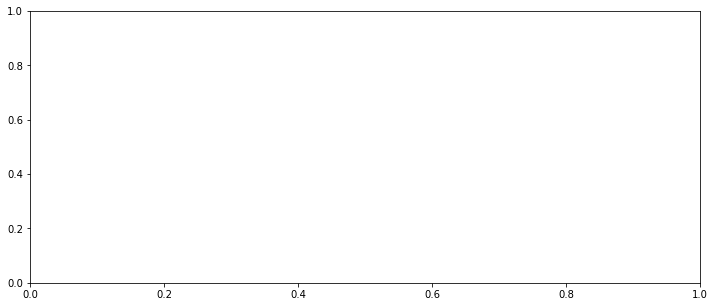

In [34]:
n_inducing = 50
z = jnp.linspace(-3.0, 3.0, n_inducing).reshape(-1, 1)

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(xtest, ytest, label="Latent function", color='tab:blue')
ax.plot(x, y, "o", color="tab:orange",  alpha=0.4, label="Observations", markersize=2.5)
[ax.axvline(x=z_i, color="tab:gray", alpha=0.3, linewidth=1) for z_i in z]
ax.legend(loc="best")
plt.show()

In [36]:
likelihood = gpx.Gaussian(num_datapoints=D.n)

NameError: name 'D' is not defined

In [37]:
likelihood._initialise_params(key)

NameError: name 'likelihood' is not defined

In [38]:
kernel1 = gpx.Matern32()
kernel2 = gpx.Matern32()

In [39]:
def 

SyntaxError: invalid syntax (1885169875.py, line 1)

In [88]:
gpx.initialise(kernel1, key=key)

ParameterState(params={'lengthscale': DeviceArray([1.], dtype=float64), 'variance': DeviceArray([1.], dtype=float64)}, trainables={'lengthscale': True, 'variance': True}, constrainers={'lengthscale': <bound method Lambda.forward of <distrax._src.bijectors.lambda_bijector.Lambda object at 0x7f5329fb0df0>>, 'variance': <bound method Lambda.forward of <distrax._src.bijectors.lambda_bijector.Lambda object at 0x7f5329fb0df0>>}, unconstrainers={'lengthscale': <bound method Lambda.inverse of <distrax._src.bijectors.lambda_bijector.Lambda object at 0x7f5329fb0df0>>, 'variance': <bound method Lambda.inverse of <distrax._src.bijectors.lambda_bijector.Lambda object at 0x7f5329fb0df0>>})

In [76]:
prior = gpx.Prior(kernel = gpx.RBF())
likelihood = gpx.Gaussian(num_datapoints = x.shape[0])

posterior = prior * likelihood

In [80]:
parameter_state = gpx.initialise(posterior, key=key)

In [85]:
parameter_state['constrainers']

{'kernel': {'lengthscale': <bound method Lambda.forward of <distrax._src.bijectors.lambda_bijector.Lambda object at 0x7f5329fb0df0>>,
  'variance': <bound method Lambda.forward of <distrax._src.bijectors.lambda_bijector.Lambda object at 0x7f5329fb0df0>>},
 'likelihood': {'obs_noise': <bound method Lambda.forward of <distrax._src.bijectors.lambda_bijector.Lambda object at 0x7f5329fb0df0>>},
 'mean_function': {}}

In [40]:
n = 100
noise = 0.3

x = jr.uniform(key=key, minval=-3.0, maxval=3.0, shape=(n,)).sort().reshape(-1, 1)
f = lambda x: jnp.sin(4 * x) + jnp.cos(2 * x)
signal = f(x)
y = signal + jr.normal(key, shape=signal.shape) * noise

D = gpx.Dataset(X=x, y=y)

xtest = jnp.linspace(-3.5, 3.5, 500).reshape(-1, 1)
ytest = f(xtest)

In [41]:
kernel = gpx.RBF()
prior = gpx.Prior(kernel=kernel)

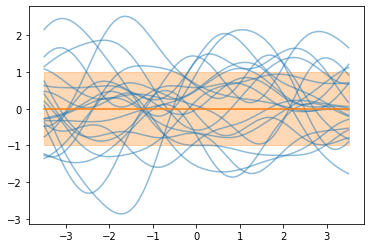

In [42]:
parameter_state = gpx.initialise(prior, key)
prior_dist = prior(parameter_state.params)(xtest)

prior_mean = prior_dist.mean()
prior_std = jnp.sqrt(prior_dist.covariance().diagonal())
samples = prior_dist.sample(seed=key,sample_shape=20).T

plt.plot(xtest, samples, color='tab:blue', alpha=0.5)
plt.plot(xtest, prior_mean, color='tab:orange')
plt.fill_between(xtest.flatten(), prior_mean - prior_std, prior_mean + prior_std, color='tab:orange', alpha=0.3)
plt.show()

In [43]:
parameter_state

ParameterState(params={'kernel': {'lengthscale': DeviceArray([1.], dtype=float64), 'variance': DeviceArray([1.], dtype=float64)}, 'mean_function': {}}, trainables={'kernel': {'lengthscale': True, 'variance': True}, 'mean_function': {}}, constrainers={'kernel': {'lengthscale': <bound method Lambda.forward of <distrax._src.bijectors.lambda_bijector.Lambda object at 0x7f3d8ebfdb10>>, 'variance': <bound method Lambda.forward of <distrax._src.bijectors.lambda_bijector.Lambda object at 0x7f3d8ebfdb10>>}, 'mean_function': {}}, unconstrainers={'kernel': {'lengthscale': <bound method Lambda.inverse of <distrax._src.bijectors.lambda_bijector.Lambda object at 0x7f3d8ebfdb10>>, 'variance': <bound method Lambda.inverse of <distrax._src.bijectors.lambda_bijector.Lambda object at 0x7f3d8ebfdb10>>}, 'mean_function': {}})

In [96]:
likelihood = gpx.Gaussian(num_datapoints=D.n)

In [97]:
posterior = prior * likelihood


In [107]:
parameter_state = gpx.initialise(posterior, key, kernel={'lengthscale': jnp.array([0.5])})
print(type(parameter_state))


<class 'gpjax.parameters.ParameterState'>


In [108]:
params, trainable, constrainer, unconstrainer = parameter_state.unpack()

In [109]:
params

{'kernel': {'lengthscale': DeviceArray([0.5], dtype=float64),
  'variance': DeviceArray([1.], dtype=float64)},
 'mean_function': {},
 'likelihood': {'obs_noise': DeviceArray([1.], dtype=float64)}}

In [110]:
params = gpx.transform(params, unconstrainer)

/tmp/ipykernel_2004415/538047788.py:1: DeprecationWarning: `transform` will be deprecated in a future release. As of v0.5.0, please use `constrain` or `unconstrain` instead.
  params = gpx.transform(params, unconstrainer)


In [111]:
params

{'kernel': {'lengthscale': DeviceArray([-0.43275213], dtype=float64),
  'variance': DeviceArray([0.54132485], dtype=float64)},
 'likelihood': {'obs_noise': DeviceArray([0.54132485], dtype=float64)},
 'mean_function': {}}

In [112]:
params = gpx.transform(params, constrainer)

/tmp/ipykernel_2004415/3477471267.py:1: DeprecationWarning: `transform` will be deprecated in a future release. As of v0.5.0, please use `constrain` or `unconstrain` instead.
  params = gpx.transform(params, constrainer)


In [113]:
params

{'kernel': {'lengthscale': DeviceArray([0.5], dtype=float64),
  'variance': DeviceArray([1.], dtype=float64)},
 'likelihood': {'obs_noise': DeviceArray([1.], dtype=float64)},
 'mean_function': {}}